In [1]:
import torch, torchvision
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 0 to use
torch.cuda.current_device()

0

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# 기존 코드와 동일한 부분
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

EPOCHS = 100
BATCH_SIZE = 64

# CIFAR-10 데이터셋을 불러옴
trainset = datasets.CIFAR10(
    root='./.data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)
testset = datasets.CIFAR10(
    root='./.data/',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
    ])
)

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
    
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


# 훈련 및 테스트 손실을 저장할 리스트 생성
train_losses = []
test_losses = []

# train 및 evaluate 함수는 그대로 사용
def train(model, train_loader, optimizer):
    running_loss = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
            
        
        
        running_loss += loss.item() * data.size(0)
    return running_loss

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

# Loss curve를 그리기 위한 리스트 생성
train_losses = []
test_losses = []

# 에폭(epoch)별로 학습 및 테스트 수행
best_acc = 0
best_loss = 1e9
best_epoch = 0

for epoch in range(1, EPOCHS + 1):
    running_loss = train(model, train_loader, optimizer)
    epoch_loss = running_loss / len(train_loader.dataset)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    # 훈련 및 테스트 손실 기록
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        best_acc = test_accuracy
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))


Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.472733
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.846370
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.276826
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.121377
[1] Test Loss: 1.0927, Accuracy: 60.66%
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.299031
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.957027
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.864654
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.087757
[2] Test Loss: 0.8616, Accuracy: 69.48%
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.906240
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.692906
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.731906
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.732623
[3] Test Loss: 0.8275, Accuracy: 71.14%
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.590534
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.599948
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.709651
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.814897
[4] Test Loss: 0.7147, A

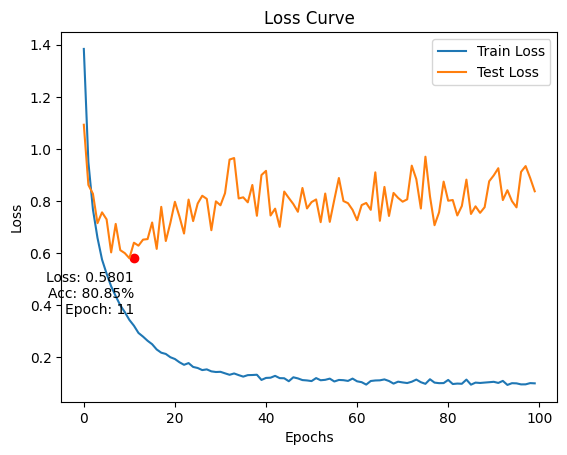

In [4]:

# Loss curve를 그림
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Loss가 가장 작은 지점에 빨간 점을 찍고 주석을 추가
plt.scatter(best_epoch, best_loss, color='red', marker='o')
plt.annotate(f'Loss: {best_loss:.4f}\nAcc: {best_acc:.2f}%\nEpoch: {best_epoch}', (best_epoch, best_loss), textcoords="offset points", xytext=(0, -40), ha='right')

plt.savefig('./plot/resnet_loss_curve.png')

In [5]:
torch.save(model.state_dict(), './save_weights/resnet.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('conv1.weight', tensor([[[[ 2.2392e-01,  2.8079e-01,  2.1484e-01],
          [ 7.9977e-02, -1.6696e-01, -2.9047e-01],
          [ 8.1276e-02, -2.2132e-01, -3.5716e-01]],

         [[ 2.2111e-01,  2.2519e-01,  1.9393e-01],
          [ 8.7178e-02, -1.3617e-01, -2.4905e-01],
          [ 1.3892e-01, -3.3537e-02, -1.5556e-01]],

         [[ 3.8298e-02,  7.7352e-02,  1.5602e-01],
          [ 8.2893e-03, -9.8323e-02, -1.3143e-01],
          [ 6.8560e-02, -6.1474e-02, -1.3734e-01]]],


        [[[ 1.5794e-01, -8.6090e-02,  1.0427e-01],
          [-1.8007e-01,  7.0129e-01, -2.4645e-01],
          [-2.5683e-01, -1.2499e-01, -5.4730e-02]],

         [[-8.8941e-02, -7.7078e-02,  4.9999e-02],
          [-2.4065e-01,  7.8818e-01, -1.7927e-01],
          [-1.2295e-01, -1.5693e-02, -1.4802e-01]],

         [[-1.5428e-01, -2.8443e-01, -1.6971e-02],
          [-1.7826e-01,  5.4642e-01, -2.5476e-01],
          [ 1.0094e-01,  2.4018e-01,  4.5910e-02]]],


    

In [6]:
load_model = ResNet().to(DEVICE)
load_model.load_state_dict(torch.load('./save_weights/resnet.pt'))

<All keys matched successfully>

In [7]:
load_model.eval()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=